In [1]:
import re
import os
import sys 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append("../")

In [2]:
TRIALS = 20

# Regex to extract T and E from folder names
PATTERN = r"exp_T(\d+)_E(\d+)_"

def parse_exp_name(name):
    m = re.match(PATTERN, name)
    if m:
        T = int(m.group(1))
        E = int(m.group(2))
        return T, E
    return None, None
        

In [3]:
BASE_LOG = "../logs/ArchiveII_simfold_128/" 
dfs = {}
groups = {}
for sim in ["sim60/", "sim70/", "sim80/", "sim90/"]:
    LOGS_PATH = os.path.join(BASE_LOG, sim)  
    # Detect experiment folders
    ALL_EXPS = [
        exp for exp in os.listdir(LOGS_PATH)
        if os.path.isdir(os.path.join(LOGS_PATH, exp))
    ]

    # Load csvs + parse T/E + rename experiment to "T{T}_E{E}"
    EXP_INFO = []
    for exp in ALL_EXPS:
        T, E = parse_exp_name(exp)
        if T is None:
            continue

        csv_path = f"{LOGS_PATH}{exp}/enemble_stats_{TRIALS}_trials.csv"
        if not os.path.exists(csv_path):
            continue

        dfs[sim] = pd.read_csv(csv_path)
        short_name = f"T{T}_E{E}"

        EXP_INFO.append({
            "name": short_name,  
            "T": T,
            "E": E,
            "df": dfs[sim]
        })

    
    groups[sim] = {} 
    for item in EXP_INFO:
        T = item["T"]
        groups[sim].setdefault(T, {})[item["name"]] = item["df"]

In [4]:
def plot_consensus_mean(dfs, Ks, ax, color, sim_label):
    """Plots consensus F1 growth for multiple experiments in one axis."""

    for exp_name, df_stats in dfs.items():
        means = np.array([df_stats[f"cons_k{k}_mean"].mean() for k in Ks])
        stds  = np.array([df_stats[f"cons_k{k}_mean"].std() for k in Ks])

        ax.plot(
            Ks, means,
            marker="o",
            color=color,
            alpha=0.9,
            label=f"{sim_label}"
        )
        ax.fill_between(
            Ks,
            means - stds,
            means + stds,
            color=color,
            alpha=0.05
        )

    ax.set_xlabel("# Samples in consensus")
    # ax.set_ylabel("Mean F1 (± std)")
    ax.grid(True, alpha=0.4)


In [5]:
def plot_consensus_std(dfs, Ks, ax, color, sim_label):
    """Plots consensus F1 growth for multiple experiments in one axis."""

    for exp_name, df_stats in dfs.items():
        means = np.array([df_stats[f"cons_k{k}_std"].mean() for k in Ks])
        stds  = np.array([df_stats[f"cons_k{k}_std"].std() for k in Ks])

        ax.plot(
            Ks, means,
            marker="o",
            color=color,
            alpha=0.9,
            label=f"{sim_label}"
        )
        ax.fill_between(
            Ks,
            means - stds,
            means + stds,
            color=color,
            alpha=0.15
        )

    ax.set_xlabel("# Samples in consensus")
    ax.set_ylabel("Mean std (F1) (± std)")
    ax.grid(True, alpha=0.4)


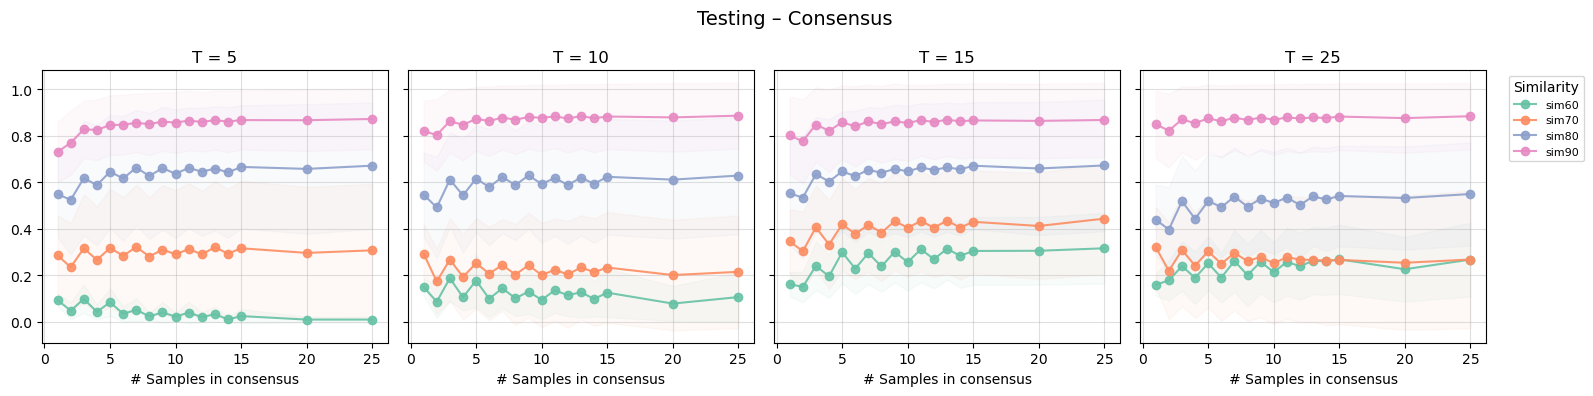

In [6]:
SIMS = ["sim60/", "sim70/", "sim80/", "sim90/"]

params = [5, 10, 15, 25]    
N_CONSENSUS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 20, 25]    

sim_palette = dict(zip(
    SIMS,
    sns.color_palette("Set2", n_colors=len(SIMS))
))


fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for sim in SIMS:
    color = sim_palette[sim]
    sim_label = sim[:-1]  # "sim60"

    for ax, p in zip(axes, params):
        plot_consensus_mean(
            dfs=groups[sim][p],
            Ks=N_CONSENSUS,
            ax=ax,
            color=color,
            sim_label=sim_label
        )
        ax.set_title(f"T = {p}")

fig.suptitle("Testing – Consensus", fontsize=14)
axes[-1].legend(
    title="Similarity",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8
)

plt.tight_layout()
plt.show()


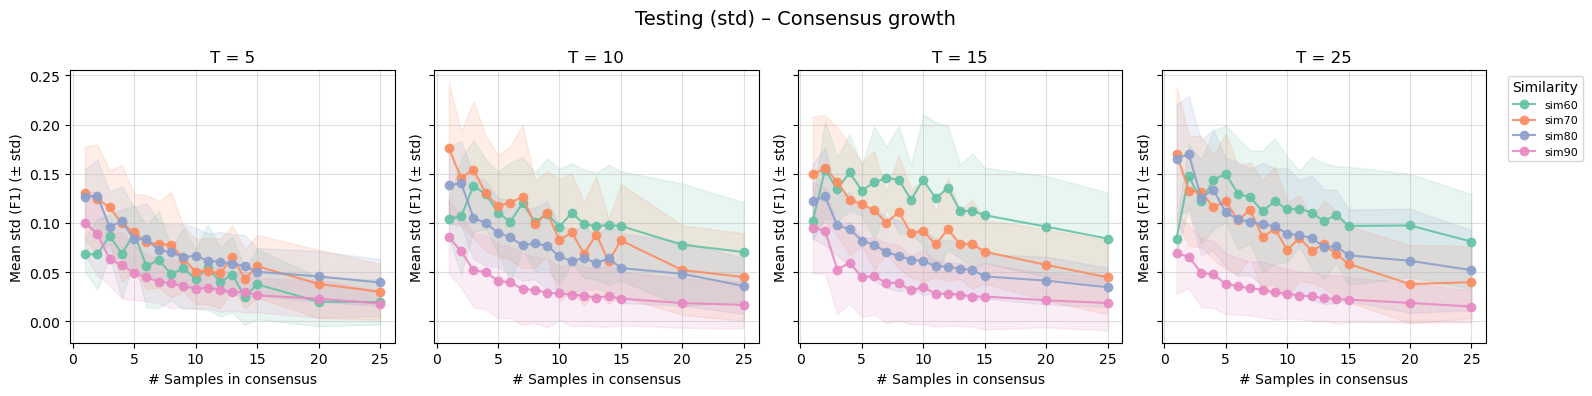

In [7]:
SIMS = ["sim60/", "sim70/", "sim80/", "sim90/"]

params = [5, 10, 15, 25]    
N_CONSENSUS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 20, 25]    

sim_palette = dict(zip(
    SIMS,
    sns.color_palette("Set2", n_colors=len(SIMS))
))


fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

for sim in SIMS:
    color = sim_palette[sim]
    sim_label = sim[:-1]  # "sim60"

    for ax, p in zip(axes, params):
        plot_consensus_std(
            dfs=groups[sim][p],
            Ks=N_CONSENSUS,
            ax=ax,
            color=color,
            sim_label=sim_label
        )
        ax.set_title(f"T = {p}")

fig.suptitle("Testing (std) – Consensus growth", fontsize=14)
axes[-1].legend(
    title="Similarity",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8
)

plt.tight_layout()
plt.show()


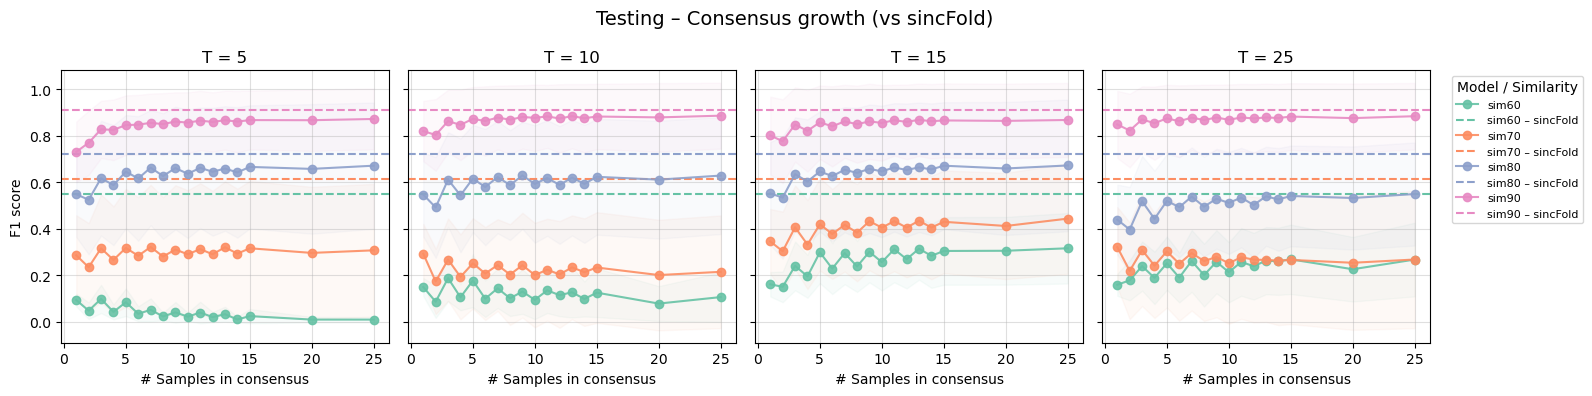

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Config
# -------------------------------
SIMS = ["sim60/", "sim70/", "sim80/", "sim90/"]
params = [5, 10, 15, 25]

N_CONSENSUS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25]
BASELINE_EPOCH = 15

# -------------------------------
# Color palette
# -------------------------------
sim_palette = dict(
    zip(SIMS, sns.color_palette("Set2", n_colors=len(SIMS)))
)
# -------------------------------
# Baseline sincFold
# -------------------------------
df_sf = pd.read_csv("../logs/ArchiveII_simfold_128/test_sincFold.csv", index_col=0) 
baseline = (
    df_sf[df_sf["epochs"] == BASELINE_EPOCH]
    .set_index("similarity")["f1"]
)

# -------------------------------
# Figure
# -------------------------------
fig, axes = plt.subplots(
    1, len(params),
    figsize=(16, 4),
    sharey=True
)

# -------------------------------
# Plot
# -------------------------------
for sim in SIMS:
    sim_label = sim.rstrip("/")        # "sim60"
    color = sim_palette[sim]
    base_f1 = baseline.loc[sim_label]

    for ax, p in zip(axes, params):
        # Diffusion + consensus
        plot_consensus_mean(
            dfs=groups[sim][p],
            Ks=N_CONSENSUS,
            ax=ax,
            color=color,
            sim_label=sim_label
        )

        # sincFold baseline
        ax.axhline(
            y=base_f1,
            color=color,
            linestyle="--",
            linewidth=1.5,
            label=f"{sim_label} – sincFold"
        )

        ax.set_title(f"T = {p}")

# -------------------------------
# Labels & legend
# -------------------------------
axes[0].set_ylabel("F1 score")
fig.suptitle("Testing – Consensus growth (vs sincFold)", fontsize=14)

# Remove duplicated legend entries
handles, labels = axes[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))

axes[-1].legend(
    unique.values(),
    unique.keys(),
    title="Model / Similarity",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=8
)

plt.tight_layout()
plt.show()


# Otras pruebas

In [26]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

def consensus_long_df(df, Ks):
    rows = []

    for k in Ks:
        col = f"cons_k{k}_mean"
        if col not in df.columns:
            continue

        tmp = df[[col]].copy()
        tmp["k"] = k
        tmp["value"] = df[col].values
        rows.append(tmp[["k", "value"]])

    return pd.concat(rows, ignore_index=True)
df = groups["sim60/"][10]["T10_E15"]
Ks = [1,2,3,4,5,10,15,20,25]

df_long = consensus_long_df(df, Ks)


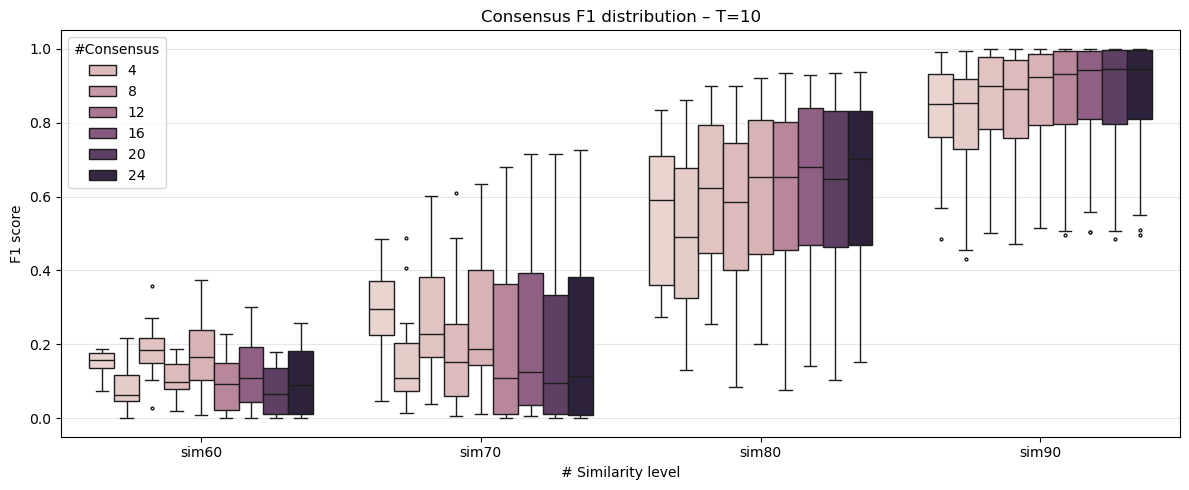

In [27]:
def consensus_long_df_with_sim(groups, sims, T, Ks):
    rows = []

    for sim in sims:
        exp_name, df = next(iter(groups[sim][T].items()))

        for k in Ks:
            col = f"cons_k{k}_mean"
            if col not in df.columns:
                continue

            rows.append(pd.DataFrame({
                "sim": sim[:-1],   # sim60
                "k": k,
                "value": df[col].values
            }))

    return pd.concat(rows, ignore_index=True)

SIMS = ["sim60/", "sim70/", "sim80/", "sim90/"]
Ks = [1,2,3,4,5,10,15,20,25]
T_FIXED = 10

df_all = consensus_long_df_with_sim(groups, SIMS, T_FIXED, Ks)
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))

sns.boxplot(
    data=df_all,
    x="sim",
    y="value",
    hue="k",
    ax=ax,
    fliersize=2,
    linewidth=1
)

ax.set_xlabel("# Similarity level")
ax.set_ylabel("F1 score")
ax.set_title(f"Consensus F1 distribution – T={T_FIXED}")
ax.grid(axis="y", alpha=0.3)

ax.legend(title="#Consensus")
plt.tight_layout()
plt.show()


In [28]:
summary = (
    df_long
    .groupby("k")["value"]
    .agg(
        mean="mean",
        std="std",
        median="median",
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
        min="min",
        max="max"
    )
    .reset_index()
)

summary


,k,mean,std,median,q25,q75,min,max
0,1,0.149228,0.038961,0.157609,0.134764,0.176024,0.073036,0.188627
1,2,0.085950,0.069464,0.063316,0.045424,0.118095,0.000000,0.218441
2,3,0.187307,0.099612,0.185694,0.150289,0.218376,0.027395,0.358202
3,4,0.105095,0.055977,0.098734,0.077847,0.147079,0.019841,0.188221
4,5,0.176973,0.114300,0.166613,0.104470,0.239671,0.008333,0.374759
5,10,0.093886,0.082964,0.092400,0.022704,0.149859,0.000000,0.228963
6,15,0.125036,0.105007,0.110268,0.044718,0.191753,0.000000,0.301871
7,20,0.078036,0.075231,0.064957,0.012742,0.136869,0.000000,0.179764
8,25,0.105919,0.106599,0.091088,0.011912,0.181945,0.000000,0.259107


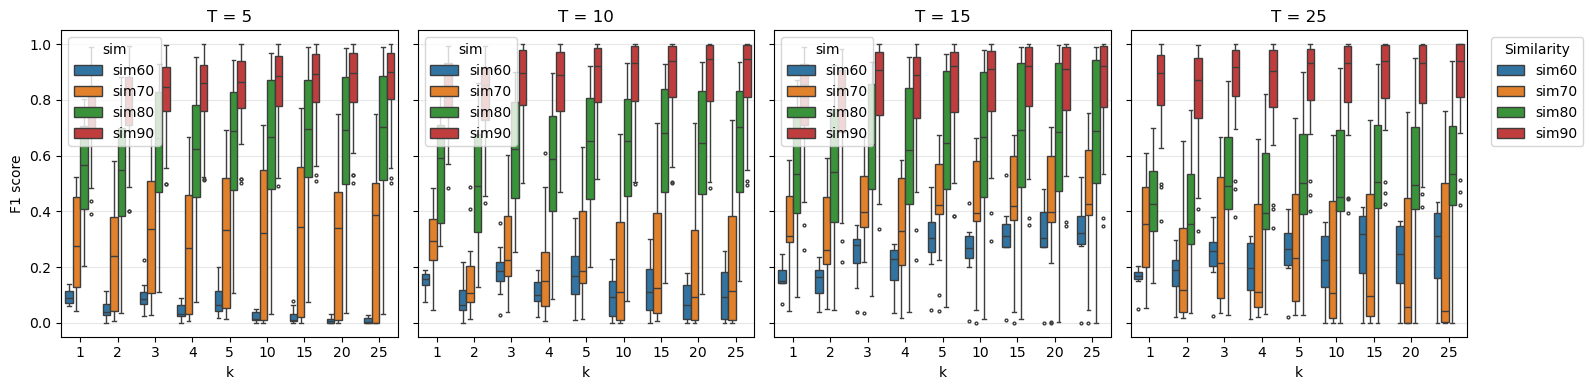

In [29]:
def consensus_long_df_all(groups, sims, Ts, Ks):
    rows = []

    for sim in sims:
        for T in Ts:
            exp_name, df = next(iter(groups[sim][T].items()))
            for k in Ks:
                col = f"cons_k{k}_mean"
                if col in df.columns:
                    rows.append(pd.DataFrame({
                        "sim": sim[:-1],
                        "T": T,
                        "k": k,
                        "value": df[col].values
                    }))
    return pd.concat(rows, ignore_index=True)
SIMS = ["sim60/", "sim70/", "sim80/", "sim90/"]
Ts   = [5, 10, 15, 25]
Ks   = [1,2,3,4,5,10,15,20,25]

df_all = consensus_long_df_all(groups, SIMS, Ts, Ks)
fig, axes = plt.subplots(1, len(Ts), figsize=(16, 4), sharey=True)

for ax, T in zip(axes, Ts):
    sns.boxplot(
        data=df_all[df_all["T"] == T],
        x="k",
        y="value",
        hue="sim",
        ax=ax,
        fliersize=2
    )
    ax.set_title(f"T = {T}")
    ax.set_xlabel("k")
    ax.grid(axis="y", alpha=0.3)

axes[0].set_ylabel("F1 score")
axes[-1].legend(title="Similarity", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [30]:
summary = (
    df_all
    .groupby(["sim", "T", "k"])["value"]
    .mean()
    .reset_index()
)
summary["T"].unique()

array([ 5, 10, 15, 25])

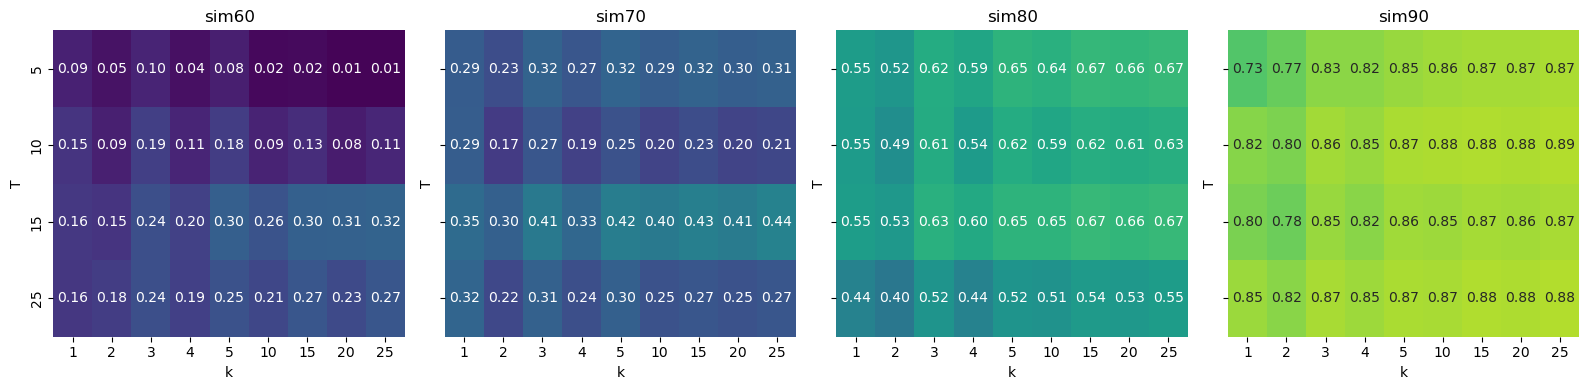

In [43]:
summary = (
    df_all
    .groupby(["sim", "T", "k"])["value"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
axes = axes.flatten()

for ax, sim in zip(axes, summary["sim"].unique()):
    mat = summary[summary["sim"] == sim].pivot(
        index="T", columns="k", values="value"
    )

    sns.heatmap(
        mat,
        ax=ax,
        cmap="viridis",
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
        cbar=False
    )
    ax.set_title(sim)

plt.tight_layout()
plt.show()


In [47]:
import torch as tr
BASE_PATH = "/home/gkulemeyer/Documents/Repos/RNADiffusion/"
raw_samples_path = BASE_PATH+"logs/ArchiveII_simfold_128/sim60/exp_T5_E15_20260129_222303/raw_samples/" 
bad_seqs ={seq_name:
    tr.load(raw_samples_path+seq_name) 
    for seq_name in os.listdir(raw_samples_path)
} 
seq_names= os.listdir(raw_samples_path)

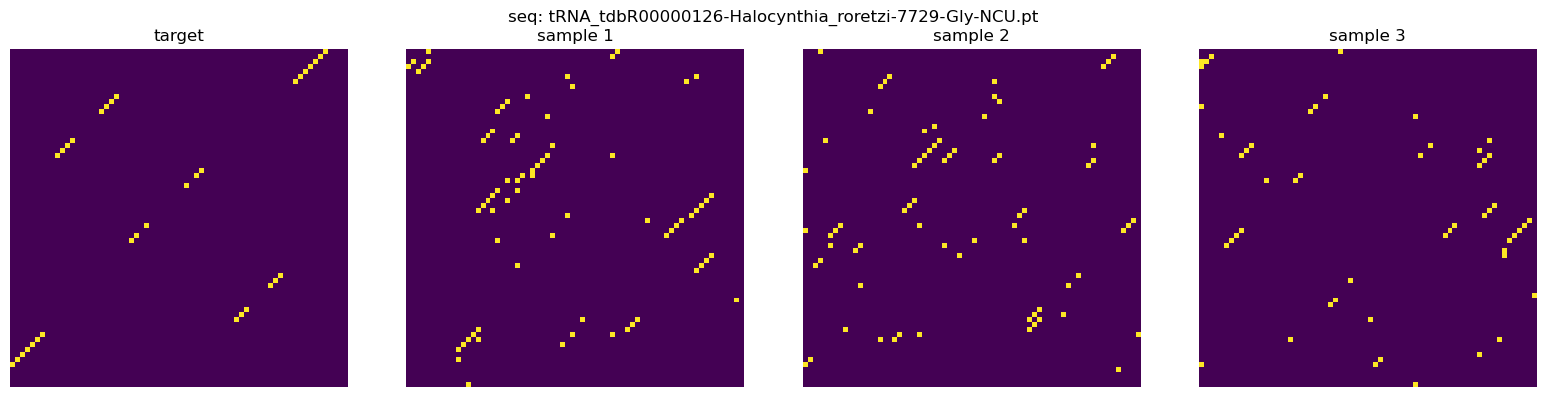

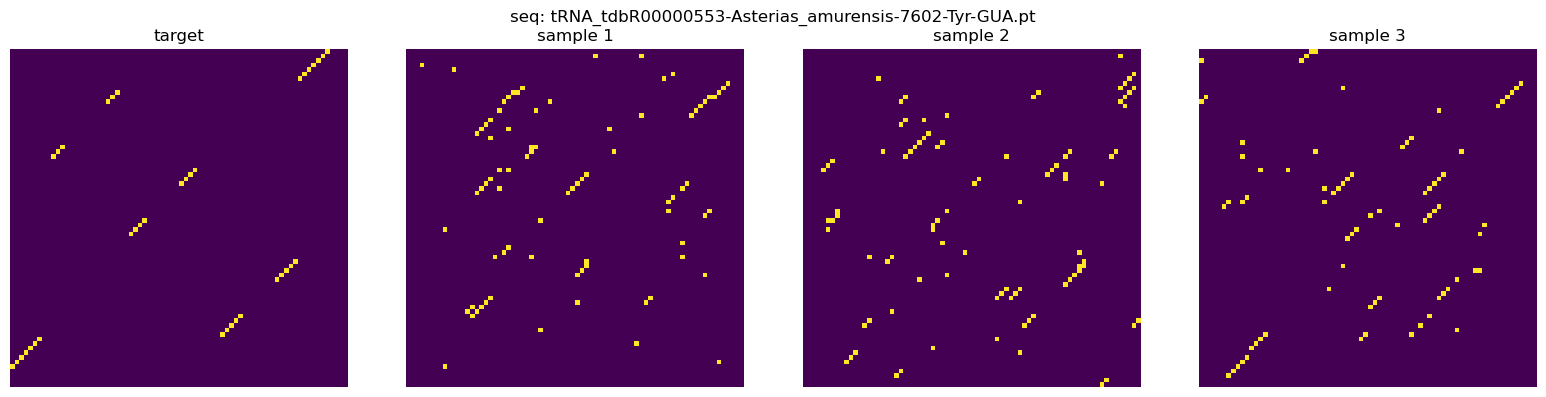

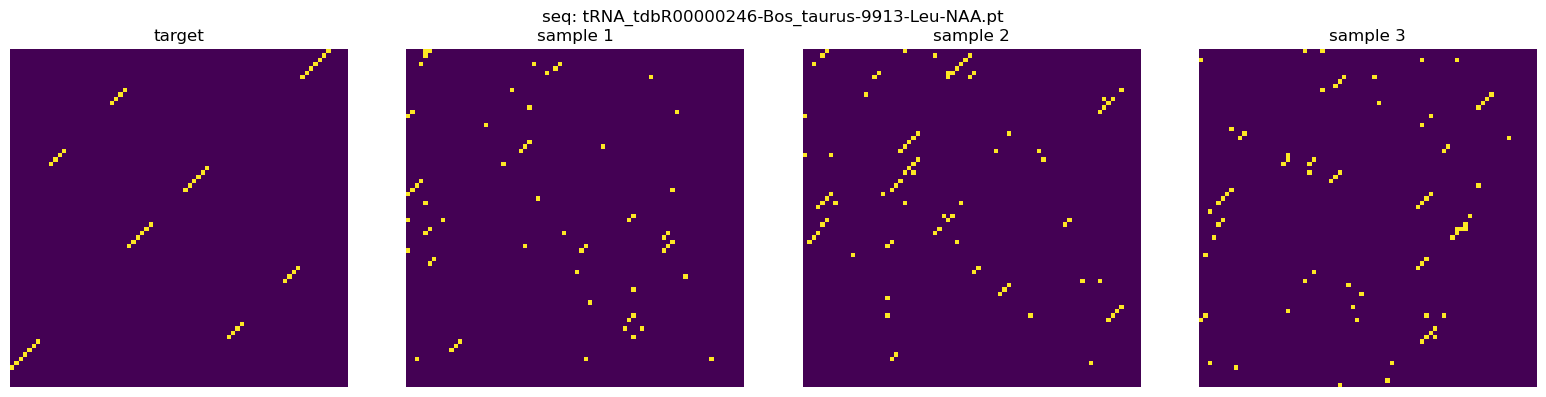

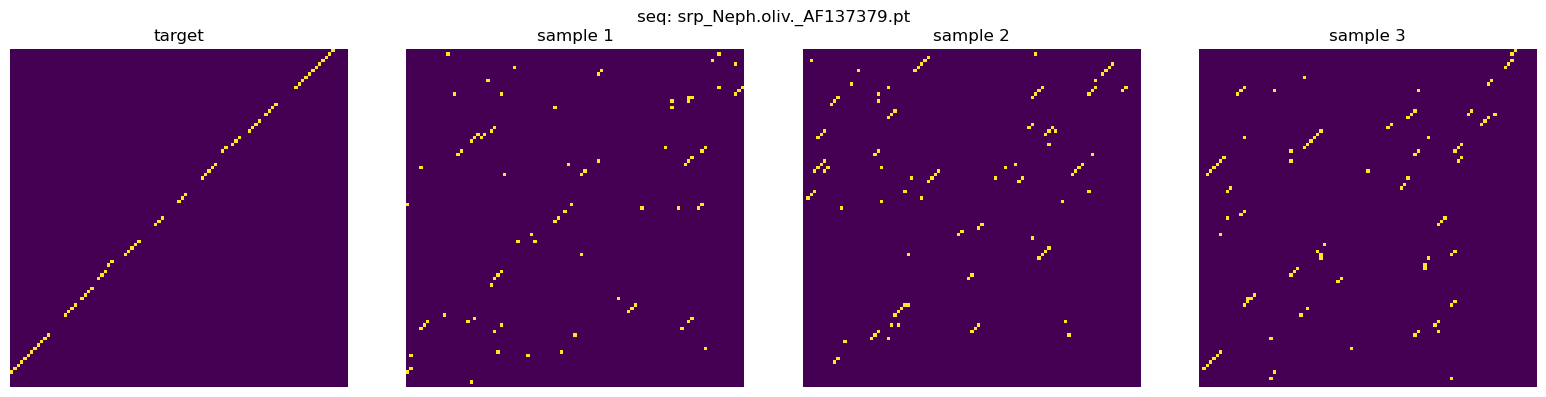

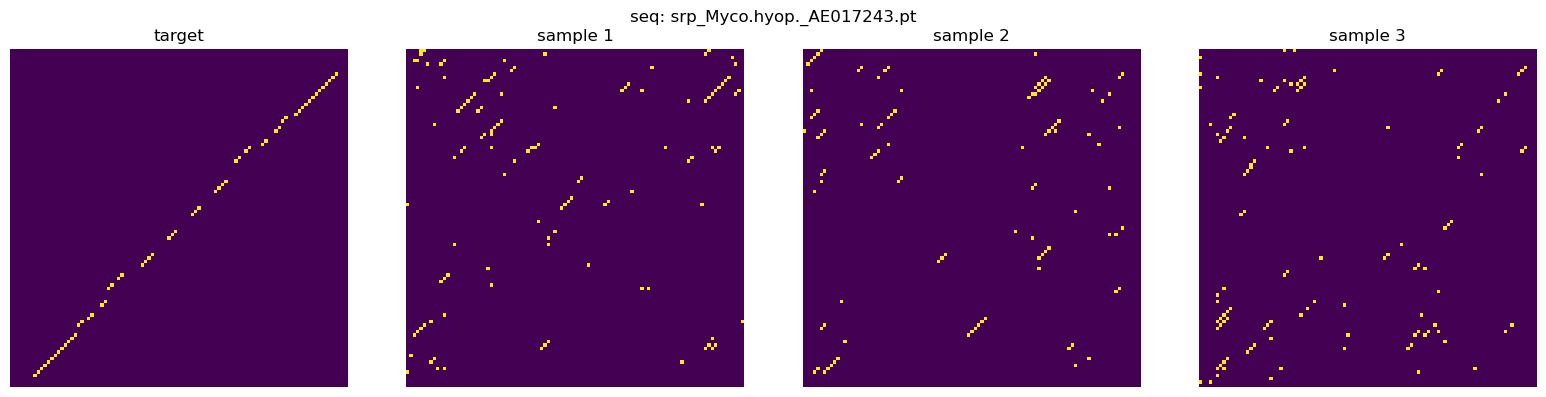

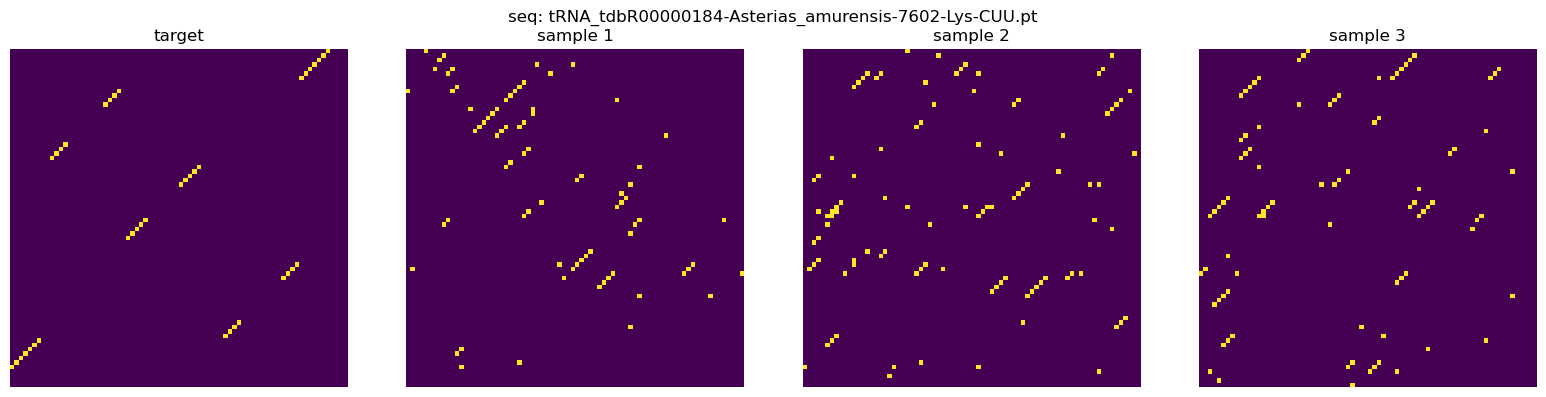

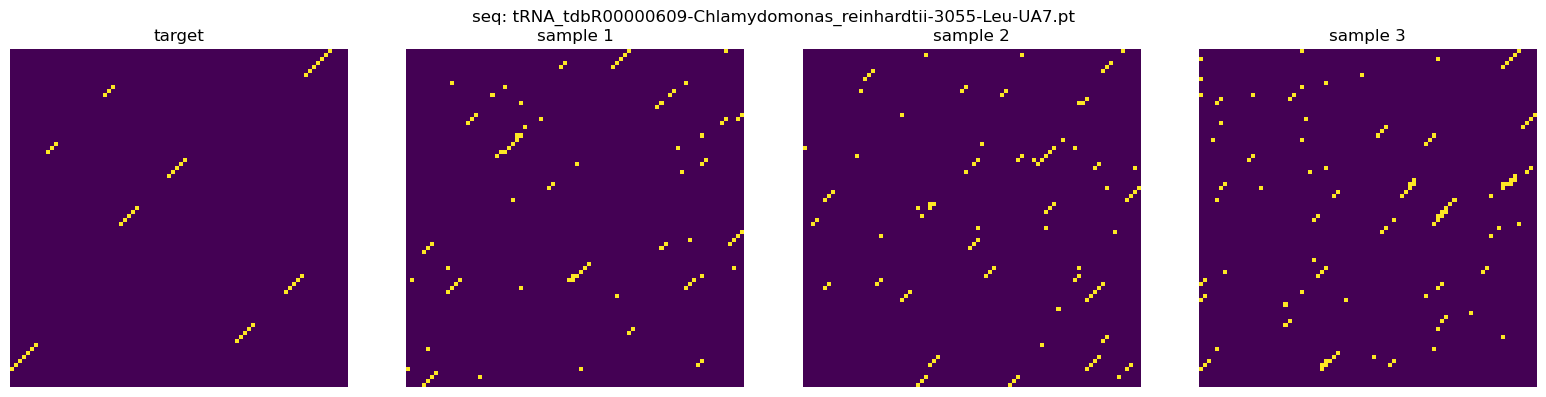

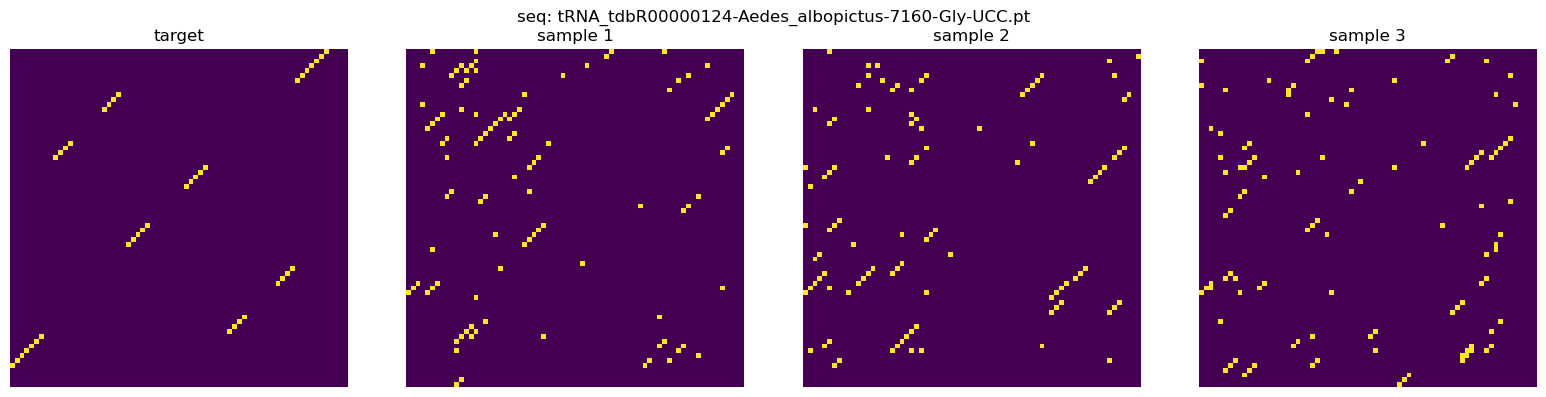

In [52]:

for seq in seq_names:
    target=bad_seqs[seq]["target"].argmax(dim=0).to("cpu")
    L = bad_seqs[seq]["length"]
    sample_1 = bad_seqs[seq]["samples"][0,:L,:L].to("cpu")
    sample_2 = bad_seqs[seq]["samples"][1,:L,:L].to("cpu")
    sample_3 = bad_seqs[seq]["samples"][2,:L,:L].to("cpu")

    fig, axs = plt.subplots(1,4,figsize= (16,4), sharex=True, sharey=True)
    axs[0].imshow(target[:L, :L])
    axs[1].imshow(sample_1)
    axs[2].imshow(sample_2)
    axs[3].imshow(sample_3)
    axs[0].set_title("target")
    axs[1].set_title("sample 1")
    axs[2].set_title("sample 2")
    axs[3].set_title("sample 3")
    for ax in axs: ax.axis("off")
    fig.suptitle(f"seq: {seq}")
    fig.tight_layout()
    plt.show()